In [1]:
%run Det3D_inference_prediction.ipynb

In [2]:
import os, sys
sys.path.insert(0, "/home/image/ohs/Det3D")
import torch

import numpy as np
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

import nuscenes
from nuscenes.nuscenes import NuScenes

# Importing from Det3D
from det3d.torchie import Config
from det3d.datasets import build_dataset, build_dataloader
from det3d.torchie.trainer.trainer import example_to_device

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # single GPU#file_path="/home/image/ohs/Det3D/examples/cbgs/configs/inference_uncertainty_config.py"
file_path ="/home/image/ohs/Det3D/examples/cbgs/configs/nusc_all_vfev3_spmiddleresnetfhd_rpn2_mghead_syncbn.py"
cfg = Config.fromfile(file_path)

nusc_val_dataset = build_dataset(cfg.data.val)
nusc_val_loader =  build_dataloader(nusc_val_dataset, 2,1, dist=False)
nusc = NuScenes(version=nusc_val_dataset.version, dataroot=str(nusc_val_dataset._root_path), verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 43.9 seconds.
Reverse indexing ...
Done reverse indexing in 13.9 seconds.


In [4]:
from det3d.models import build_detector
from det3d.torchie.trainer.checkpoint import load_checkpoint

model_file = '/home/image/ohs/Det3D/experiments/hpc_experiments/baselines/cbgs/resnet/epoch_10.pth'

model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
model.eval()
print(torch.norm(next(model.parameters())))
load_checkpoint(model, model_file)
print(torch.norm(next(model.parameters())))

tensor(0.9889, grad_fn=<NormBackward0>)
tensor(22.1841, grad_fn=<NormBackward0>)


In [15]:
example = next(iter(nusc_val_loader)) 
print(next(model.parameters()).device)

cpu


In [31]:
with torch.no_grad():
    predictions = model(example,return_loss=False,drop_rate=0.5)

<IPython.core.display.Javascript object>


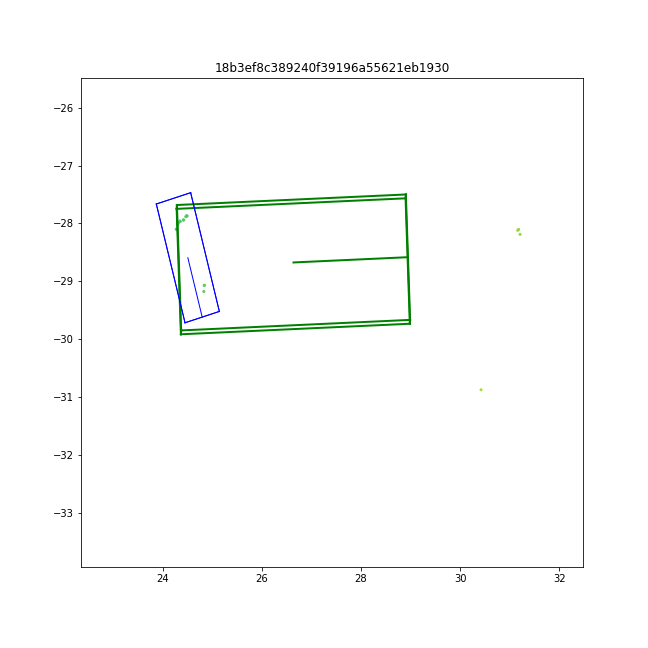

Rendering sample token 18b3ef8c389240f39196a55621eb1930


In [32]:
visualize_prediction(nusc, predictions, index=0, conf_th=0.2)

<IPython.core.display.Javascript object>


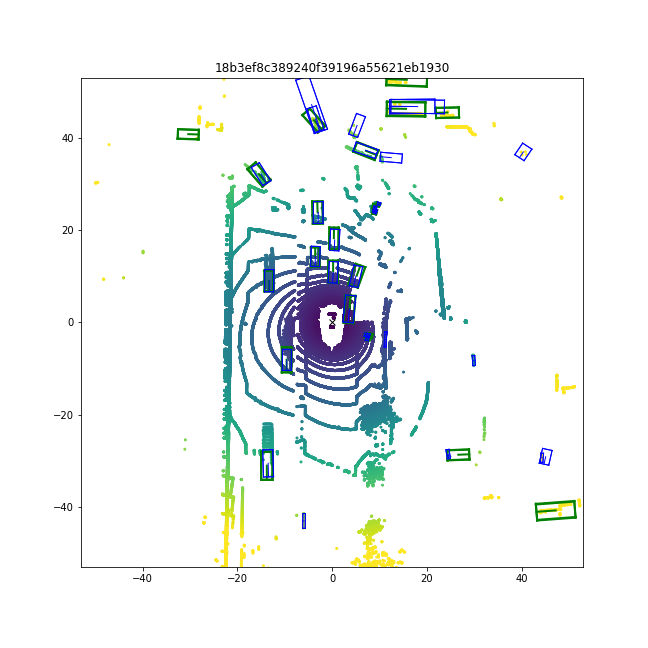

Rendering sample token 18b3ef8c389240f39196a55621eb1930


In [27]:
visualize_prediction(nusc, predictions, index=0, conf_th=0.2)

In [29]:
gt_boxes = [frame_annos['boxes'] for frame_annos in data['annos']]

In [37]:
torch.from_numpy(np.concatenate(gt_boxes)).float().to(torch.cuda.current_device())

torch.Size([46, 9])

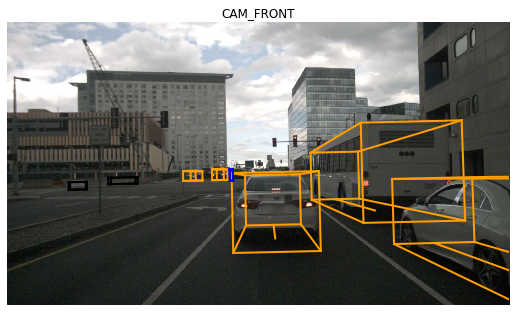

In [16]:
%matplotlib inline
index=0
sample = nusc.get('sample', example['metadata'][index]['token'])
nusc.render_sample_data(sample['data']['CAM_FRONT'])